In [30]:
import sys
import numpy as np
import scipy.special as sps
from tqdm import tqdm_notebook
import pickle
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init_common as x
import helpers as hp
import json

sns.set(rc={'figure.figsize':(11, 4)})
R0_array=[1.58, 1.48]
alpha_array=[1,1]
N = len(alpha_array)
col_array = ['blue','green','orange','red']
tstat_95 = 2.262
data_array = []

def load_data(p):
    with open(p+"/simul_SIR.pickle",'rb') as fid:
        ax = pickle.load(fid)
    fid.close()
    with open(p+"/info.json",'r') as fid:
        bx = json.load(fid)
    return ax,bx

out_filename_dirs = []
out_fig_dirs = []
for i in np.arange(N):
    out_filename_dir,out_fig_dir,out_stat_dir=hp.get_paths(R0_array[i],alpha_array[i])
    out_filename_dirs.append(out_filename_dir)
    out_fig_dirs.append(out_fig_dir)
    data,info_dic = load_data(out_filename_dir)
    data_array.append(data)

Basic Statistics: number of infected people, R0 = 1.48
Peak, mean value:  115.0  day:  36
Peak, mean+2*std value :  387.0  day:  36
Peak, mean-2*std value :  46.0  day:  36


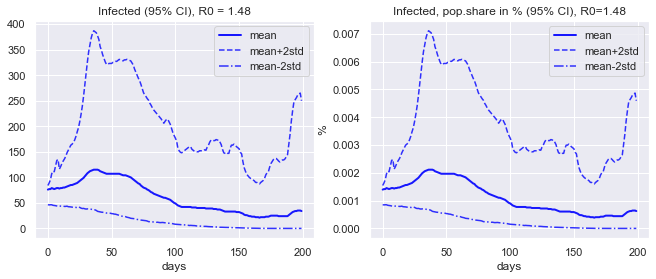

In [33]:
# Basic statistics
# 1. Peak of infected, 95% CI
idx=1
data = data_array[idx]
R0 = R0_array[idx]
I_mean = hp.mean_list(data,'inf',ma=True,w=10)
I_std = hp.std_list(data,'inf',ma=True,w=10)
print("Basic Statistics: number of infected people, R0 = "+ str(np.round(R0,2)))
m = np.round(x.N_popul_size*np.array(I_mean)/x.first_infections_correction_multiplier)
s = np.round(x.N_popul_size*np.array(I_std)/x.first_infections_correction_multiplier)
m1=m+2*s
xval=np.arange(0,x.N_per)
m0 = hp.fun_log_list(data,'inf',fun=np.mean,ma=False,w=10,s=x.N_popul_size/x.first_infections_correction_multiplier)
s0 = hp.fun_log_list(data,'inf',fun=np.std,ma=False,w=10,s=x.N_popul_size/x.first_infections_correction_multiplier)
ds0 = tstat_95*s0/x.N_simul**.5
m2 = np.exp(m0-ds0)
print('Peak, mean value: ',np.round(m.max()),' day: ',m.argmax())
print('Peak, mean+2*std value : ',np.round(m1.max()),' day: ',m1.argmax())
print('Peak, mean-2*std value : ',np.round(m2.max()),' day: ',m1.argmax())    

plt.subplot(121)
plt.plot(xval,m,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,m1,color='blue',linestyle='--',alpha=.8)
plt.plot(xval,m2,color='blue',linestyle='-.',alpha=.8)
plt.legend(['mean', 'mean+2std', 'mean-2std'])
plt.xlabel("days")
plt.title("Infected (95% CI), R0 = "+ str(np.round(R0,2)))

m = 100*m/x.N_popul_size
m1 = 100*m1/x.N_popul_size
m2 = 100*m2/x.N_popul_size
plt.subplot(122)
plt.plot(xval,m,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,m1,color='blue',linestyle='--',alpha=.8)
plt.plot(xval,m2,color='blue',linestyle='-.',alpha=.8)
plt.legend(['mean', 'mean+2std', 'mean-2std'])
plt.ylabel("%")
plt.xlabel("days")
plt.title("Infected, pop.share in % (95% CI), R0="+ str(np.round(R0,2)))

plt.savefig(out_fig_dirs[idx]+"/peaks.png",dpi=300)
                

Text(0.5, 1.0, 'Evolution of changes in infected (%)')

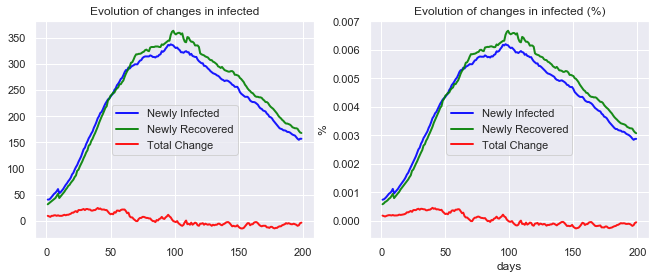

In [16]:
def mean_diff_list(x,colname,w=10):
    u = pd.array(x[0][colname])
    z = pd.DataFrame(u[1:]-u[:-1])
    z_mean = z
    n = len(x)
    if n>1:
        for idx in np.arange(n):
            u = pd.array(x[idx][colname])
            z = pd.concat([z,pd.DataFrame(u[1:]-u[:-1])],1)
        z_mean = z.apply(np.mean,1)
        z_mean0 = z_mean.rolling(window=w).mean()
        z_mean0[0:w-1] = z_mean.rolling(window=2).mean()[0:w-1]
        z_mean[1:]=z_mean0[1:]
    return z_mean

I_in = np.round(-x.N_popul_size*np.array(mean_diff_list(data,'sus'))/x.first_infections_correction_multiplier)
I_out = np.round(x.N_popul_size*np.array(mean_diff_list(data,'rec'))/x.first_infections_correction_multiplier)
dI = np.round(x.N_popul_size*np.array(mean_diff_list(data,'inf'))/x.first_infections_correction_multiplier)
xval = np.arange(1,x.N_per)

plt.subplot(121)
plt.plot(xval,I_in,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_out,color='green',linewidth=2,alpha=.9)
plt.plot(xval,dI,color='red',linewidth=2,alpha=.9)
plt.legend(['Newly Infected','Newly Recovered','Total Change'])
plt.title('Evolution of changes in infected')

plt.savefig(out_fig_dir+"change.png",dpi=300)

I_in = -100*np.array(mean_diff_list(data,'sus'))/x.first_infections_correction_multiplier
I_out = 100*np.array(mean_diff_list(data,'rec'))/x.first_infections_correction_multiplier
dI = 100*np.array(mean_diff_list(data,'inf'))/x.first_infections_correction_multiplier
xval = np.arange(1,x.N_per)
plt.subplot(122)
plt.plot(xval,I_in,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_out,color='green',linewidth=2,alpha=.9)
plt.plot(xval,dI,color='red',linewidth=2,alpha=.9)
plt.legend(['Newly Infected','Newly Recovered','Total Change'])
plt.xlabel("days")
plt.ylabel("%")
plt.title('Evolution of changes in infected (%)')


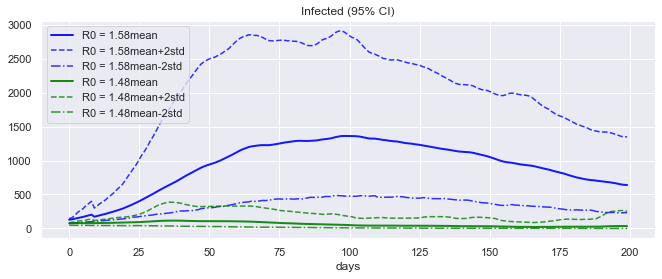

In [32]:
# Basic statistics
# 1. Peak of infected, 95% CI
idx=0

leg = []
for idx in np.arange(N):
    data = data_array[idx]
    R0 = R0_array[idx]
    I_mean = hp.mean_list(data,'inf',ma=True,w=10)
    I_std = hp.std_list(data,'inf',ma=True,w=10)
    m = np.round(x.N_popul_size*np.array(I_mean)/x.first_infections_correction_multiplier)
    s = np.round(x.N_popul_size*np.array(I_std)/x.first_infections_correction_multiplier)
    m1=m+2*s
    xval=np.arange(0,x.N_per)
    m0 = hp.fun_log_list(data,'inf',fun=np.mean,ma=False,w=10,s=x.N_popul_size/x.first_infections_correction_multiplier)
    s0 = hp.fun_log_list(data,'inf',fun=np.std,ma=False,w=10,s=x.N_popul_size/x.first_infections_correction_multiplier)
    ds0 = tstat_95*s0/x.N_simul**.5
    m2 = np.exp(m0-ds0)
    plt.plot(xval,m,color=col_array[idx],linewidth=2,alpha=.9)
    plt.plot(xval,m1,color=col_array[idx],linestyle='--',alpha=.8)
    plt.plot(xval,m2,color=col_array[idx],linestyle='-.',alpha=.8)
    leg.append("R0 = "+ str(np.round(R0,2))+" mean")
    leg.append("R0 = "+ str(np.round(R0,2))+" mean+2std")
    leg.append("R0 = "+ str(np.round(R0,2))+" mean-2std")
plt.xlabel("days")
plt.title("Infected (95% CI)")
plt.legend(leg)
